# A regularization problem example: 1D Podracing

Let's revisit the podracing problem but in a simplified, 1-dimensional setting. Now our only requirements are that we start at rest (velocity 0) at time 0 and position 0 and finish at rest (velocity 0) at time 50 and position 100. We want to minimize the thrust required to achieve this, but we will measure thrust with different norms to see how the behavior changes.

## Let's start with the unsimplified version containing 150 variables:

In [1]:
using JuMP, Gurobi

m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m,"OutputFlag",false)
T = 50                # length of time horizon
@variable(m, x[1:T])    # resulting position
@variable(m, v[1:T])    # resulting velocity
@variable(m, u[1:T-1])  # thruster input

# constraint on start and end positions and velocities
@constraint(m, x[1] == 0)
@constraint(m, v[1] == 0)
@constraint(m, x[T] == 100)
@constraint(m, v[T] == 0)

# satisfy the simple system dynamics for every time period
for i = 1:T-1
    @constraint(m, x[i+1] == x[i] + v[i]) # position is calculated as previous position + velocity
    @constraint(m, v[i+1] == v[i] + u[i]) # velocity is calculated as previous velocity + thrust
end

# minimize 2-norm
@objective(m, Min, sum(u.^2) )

optimize!(m)
uopt = value.(u); # store the solution

Academic license - for non-commercial use only - expires 2022-06-27


## Plotting the thruster inputs
We can visualize the behavior of minimizing the 2-norm as follows:

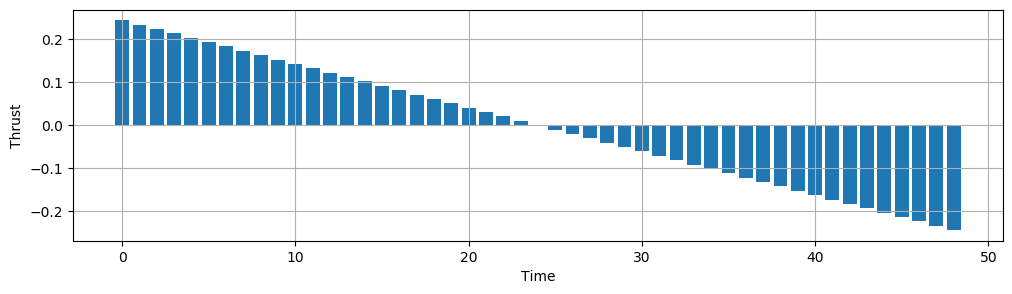

In [2]:
using PyPlot
figure(figsize=(12,3))
bar( 0:T-2, uopt );
xlabel("Time"); ylabel("Thrust"); grid()

## More comact podracing model

We can greatly reduce the model complexity using the identities shown in the lecture. Let's reformulate this model and create a function that allows us to select different norms for the objective.

In [3]:
T = 50      # length of time horizon

m = Model(Gurobi.Optimizer)

@variable(m, u[1:T-1])  # thruster inputs are our only variables

# matrix and vector found using substitutions to reduce problem dimension
A = [(48:-1:0)'; ones(1,49)]
b = [100; 0]

@constraint(m, A*u .== b) # only constraint is that Au=b

# 1-norm version (refomulate as LP with epigraph trick)
@variable(m, t[1:T-1])
@constraint(m, u .<= t )
@constraint(m, -t .<= u )

# ∞-norm (reformulate as LP with epigraph trick)
@variable(m, r)
@constraint(m, u .<= r )
@constraint(m, -r .<= u )

# case = norms we select. 
# λ parameter allows us to combine norms in the objective with different relative weights
λ = 1
uopt = Dict()
for case in [:two, :one, :inf, :two_one, :two_inf, :inf_one, :everything]
    if case == :two
        @objective(m, Min, sum(u.^2)) # 2-norm
    elseif case == :one
        @objective(m, Min, sum(t)) # 1-norm
    elseif case == :inf
        @objective(m, Min, r) # ∞-norm 
    elseif case == :two_one
        @objective(m, Min, sum(u.^2) + λ*sum(t))  # lasso
    elseif case == :two_inf
        @objective(m, Min, sum(u.^2) + λ*r)  # L-inf regularization
    elseif case == :inf_one
        @objective(m, Min, r + λ*sum(t))# inf norm with L-1 regularization
    elseif case == :everything
        @objective(m, Min, sum(u.^2) + sum(t) + r) # all norms
    end
    
    # solve for each case and store value
    set_optimizer_attribute(m,"OutputFlag",false)
    optimize!(m)
    println(case)
    println(objective_value(m))
    uopt[case] = value.(u);
end


Academic license - for non-commercial use only - expires 2022-06-27
two
1.0204081632653057
one
4.166666666666667
inf
0.16666666666666655
two_one
6.1982357269562405
two_inf
1.2352473317307382
inf_one
4.999999999999999
everything
6.5494994161695965


## Plot thruster input

Let's see how the thruster input varies for each choice of norm.

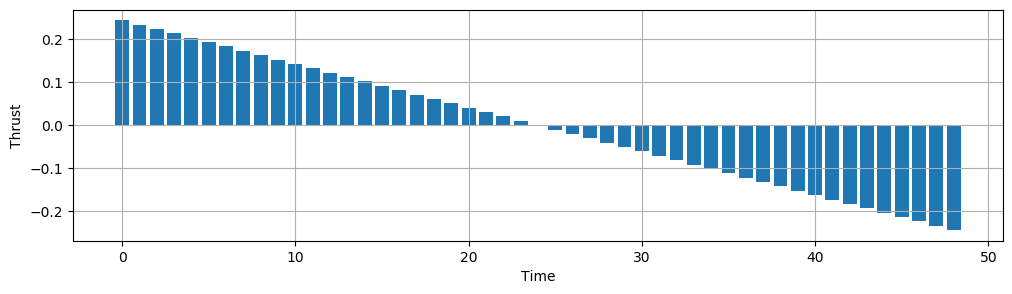

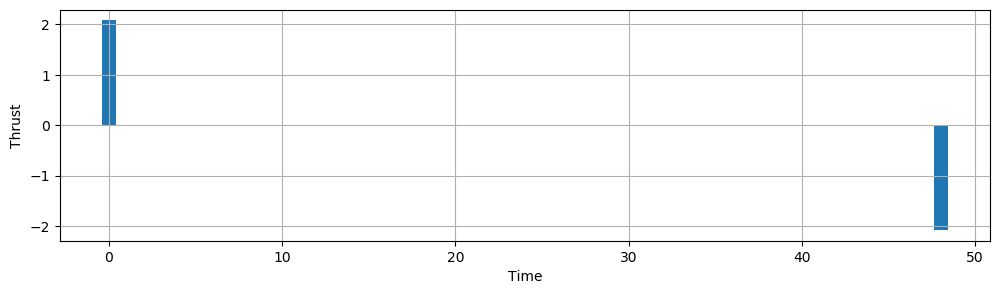

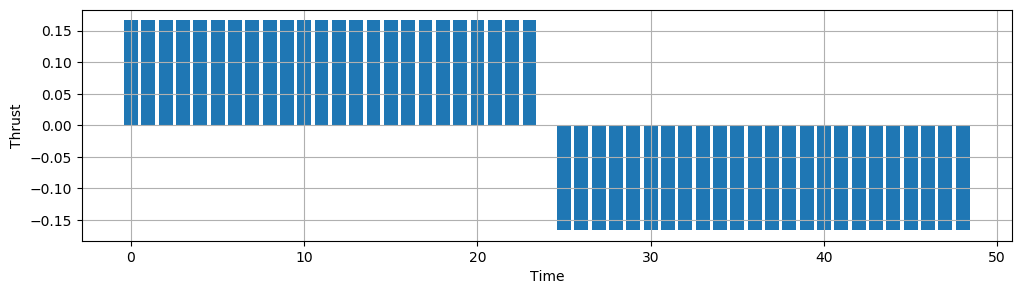

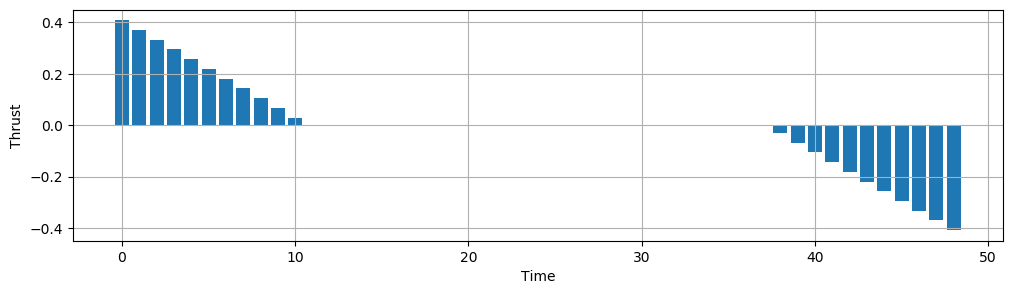

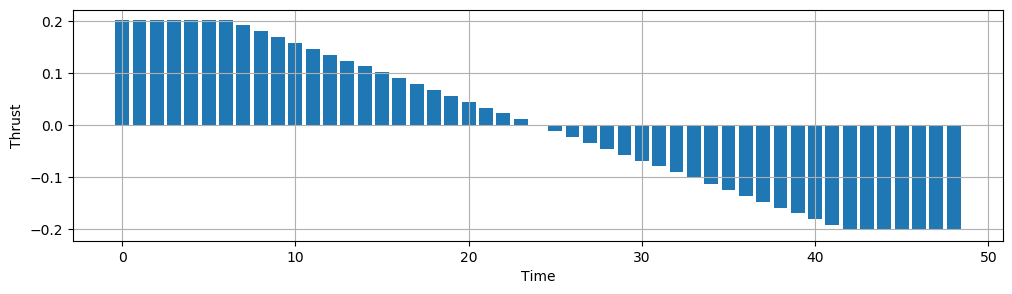

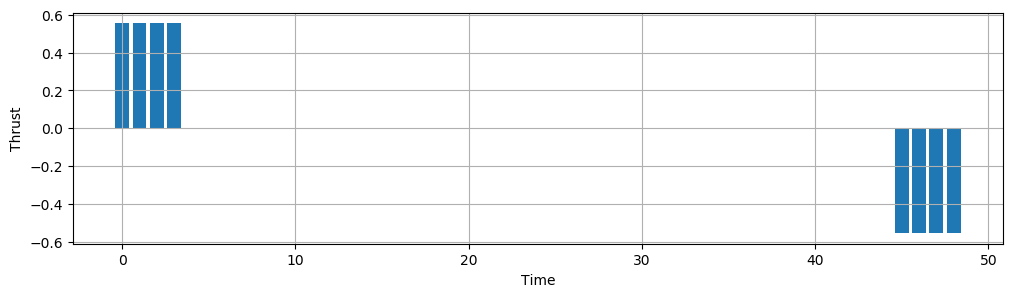

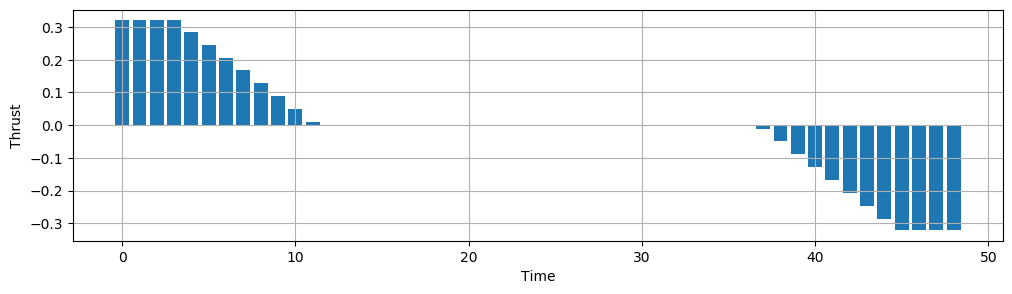

In [4]:
using PyPlot
for case in [:two, :one, :inf, :two_one, :two_inf, :inf_one, :everything]

    figure(figsize=(12,3))
    bar( 0:T-2, uopt[case] );
    xlabel("Time"); ylabel("Thrust"); grid()
end